In [1]:
# Cell 1 - import the things you need
import logging
import sys

import numpy as np
import pandas as pd

from hamilton import ad_hoc_utils, driver

logging.basicConfig(stream=sys.stdout)

In [2]:
# Cell 2 - import modules to create part of the DAG from
# We use the autoreload extension that comes with ipython to automatically reload modules when
# the code in them changes.

# import the jupyter extension
%load_ext autoreload
# set it to only reload the modules imported
%autoreload 1
# import the function modules you want to reload when they change.
# i.e. these should be your modules you write your functions in. As you change them,
# they will be reimported without you having to do anything.
%aimport my_functions

In [3]:
# Cell 3 - Define your new Hamilton functions & curate them into a TemporaryFunctionModule object.
# This enables you to add functions to your DAG without creating a proper module.
# This is ONLY INTENDED FOR QUICK DEVELOPMENT. For moving to production move these to an actual module.

# Look at `my_functions` to see how these functions connect.
def signups() -> pd.Series:
    """Returns sign up values"""
    return pd.Series([1, 10, 50, 100, 200, 400])


def spend() -> pd.Series:
    """Returns the spend values"""
    return pd.Series([10, 10, 20, 40, 40, 50])


def log_spend_per_signup(spend_per_signup: pd.Series) -> pd.Series:
    """Simple function taking the logarithm of spend over signups."""
    return np.log(spend_per_signup)


# Place the functions into a temporary module -- the idea is that this should house a curated set of functions.
# Don't be afraid to make multiple of them -- however we'd advise you to not use this method for production.
# Also note, that using a temporary function module does not work for scaling onto Ray, Dask, or Pandas on Spark.
temp_module = ad_hoc_utils.create_temporary_module(
    spend, signups, log_spend_per_signup, module_name="function_example"
)

In [4]:
# Cell 4 - Instantiate the Hamilton driver and pass it the right things in.

initial_config = {}
# we need to tell hamilton where to load function definitions from
dr = driver.Driver(initial_config, my_functions, temp_module)  # can pass in multiple modules
# we need to specify what we want in the final dataframe.
output_columns = [
    "spend",
    "signups",
    "avg_3wk_spend",
    "spend_per_signup",
    "spend_zero_mean_unit_variance",
]

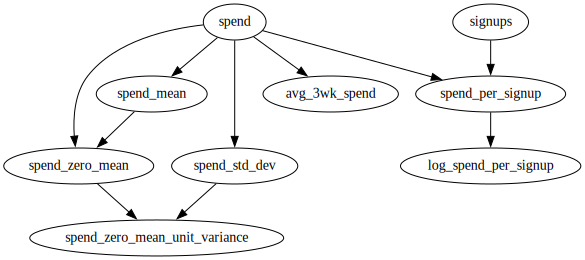

In [5]:
# Cell 5 - visualize execution
# To visualize do `pip install "sf-hamilton[visualization]"` if you want these to work

# visualize all possible functions
dr.display_all_functions(None)  # we pass None to not save the image to file.

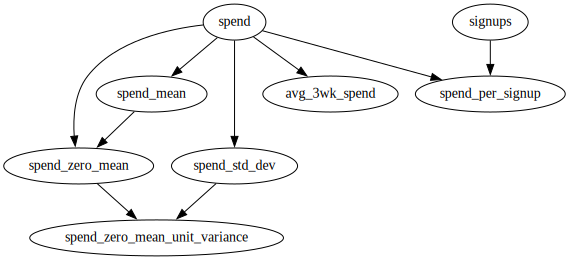

In [6]:
# visualize just the execution path
dr.visualize_execution(output_columns, None, {})   # we pass None to not save the image to file.

In [7]:
# let's create the dataframe!
dr.execute(output_columns)

,spend,signups,avg_3wk_spend,spend_per_signup,spend_zero_mean_unit_variance
0,10,1,NaN,10.000,-1.064405
1,10,10,NaN,1.000,-1.064405
2,20,50,13.333333,0.400,-0.483821
3,40,100,23.333333,0.400,0.677349
4,40,200,33.333333,0.200,0.677349
5,50,400,43.333333,0.125,1.257934
